<a href="https://colab.research.google.com/github/LorisRB/plane-classification/blob/main/notebooks/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  8527k      0  0:05:15  0:05:15 --:--:-- 26.4M


# Imports


In [73]:
# baselib par abc
import pathlib

# import par abc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# from par apc
#from...

from sklearn.model_selection import train_test_split


#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

In [3]:
DATA_DIR = pathlib.Path('dataset/data')

In [4]:
pd.__version__

'1.3.5'

In [5]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=' ',
            names=['image_id', 'manufacturer'],
            usecols=['image_id', 'manufacturer'], # usecols for v1.4 compatibility
            dtype={'image_id': str},              # ids are not int but string
           )

## Verify data

In [6]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
Cessna         133
British        133
Lockheed       102
Fokker         100
Dassault        67
Gulfstream      67
Beechcraft      67
Saab            67
Tupolev         66
ATR             66
Panavia         34
Antonov         34
Dornier         34
Yakovlev        34
Bombardier      33
Ilyushin        33
Fairchild       33
Piper           33
Cirrus          33
Eurofighter     33
Supermarine     33
Robin           33
Name: manufacturer, dtype: int64

In [7]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [8]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Valeur manquante dans image_id"
assert manufacturer_df['manufacturer'].isna().sum() == 0, "Valeur manquante dans manufacturer"

## Deal with N columns

In [9]:
! grep ',' dataset/data/images_manufacturer_train.txt

In [10]:
# Recherche le caractère T dans le fichier et n'affiche que trois lignes (head -3)
! grep 'T' dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [11]:
# wc : compte le nombre d'éléments (-l : ligne, -c : caractère, -w : word)
! grep 'T' dataset/data/images_manufacturer_train.txt | wc -l

132


In [12]:
!cut -f 1 -d ' ' dataset/data/images_manufacturer_train.txt | head -3

1025794
1340192
0056978


In [13]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep='\t',
            names=['all'],
            dtype={'all': str},              # ids are not int but string
           )

# La fonction split() découpe une chaîne de caractères
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

# La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [14]:
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [15]:
manufacturer_df.head()

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing


In [19]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x+'.jpg'))

In [20]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


In [ ]:
def build_image_database(path):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information

  Returns
  --------
  A pandas dataframe, including target class and path to image
  """
  manufacturer_df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str},              # ids are not int but string
           )

# La fonction split() découpe une chaîne de caractères
  manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

# La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))
# La colonne path contient le chemin d'accès à l'image
  manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x+'.jpg'))
  return manufacturer_df

In [ ]:
build_image_database()

In [26]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information
  target (str): name of the target column

  Returns
  --------
  A pandas dataframe, including target class and path to image
  """
  # _df: commence par _ : variable pas importante
  # __df: variable privée
  _df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str},              # ids are not int but string
           )

# La fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

# La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x+'.jpg'))
  return _df.drop(columns=['all'])

In [27]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer').head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [25]:
build_image_database(DATA_DIR / 'images_family_train.txt', 'family').head(2)

,all,image_id,family,path
0,1025794 Boeing 707,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192 Boeing 707,1340192,Boeing 707,dataset/data/images/1340192.jpg


In [31]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [33]:
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg


In [44]:
manufacturer_df.head(1)['path'].values[0]

PosixPath('dataset/data/images/1025794.jpg')

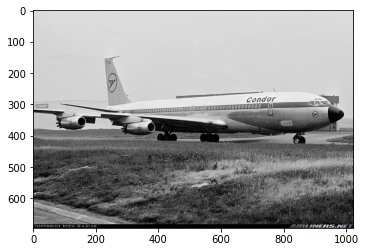

In [45]:
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

In [47]:
# la fonction :
# -prend un df (argument)
# -prend une ligne (row: argument, indice)
# -prend une colonne (target: argument)
# -elle affiche la classe (valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target):
  """ Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target(str): name of the target column
"""
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  
  return 


Boeing


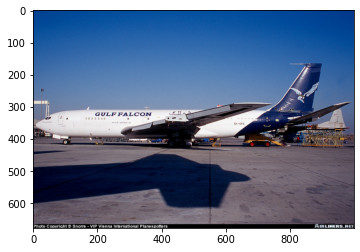

In [49]:
show_image(manufacturer_df, row=21, target='manufacturer')

In [62]:
manufacturer_df.shape

(3334, 3)

In [63]:
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [66]:
manufacturer_df["shape"] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [68]:
# Distribution du nombre de lignes
manufacturer_df["shape"].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape, Length: 404, dtype: int64

In [69]:
# Distribution du nombre de colonnes
manufacturer_df["shape"].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [70]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH

In [74]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size

  Parameters
  -----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width

  Returns
  ----------
  np.array
  """

  return np.array(Image.open(path).resize((width, height)))

In [75]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT, IMAGE_WIDTH ), axis=1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [77]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT, IMAGE_WIDTH ), axis=1)

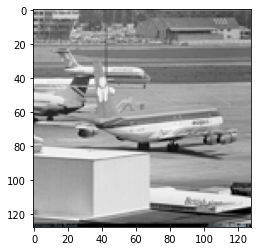

In [78]:
plt.imshow(manufacturer_df.iloc[1,]['resized_image'])

In [60]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: ignored